## PART 1: Initial analysis
#### COVID cases and mask mandate analysis for Macomb County, Michigan.
In this part of the notebook, we will explore the impact of mask mandate in the number and percent change of confirmed cases in Macomb County, Michigan ranging from Feb 2020 to October 2022. The analysis begins with data manipulation to process the data into the format that is needed to plot the visualisations. Comments and explanation will be included in the notebook as markdown in order to guide the reader throughout the analysis.

### Reading in Data

In [71]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

# Import stats library
from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats

Users can insert their file path here in order to reuse the notebook. Should the users are interested to study a different state or county, change the target_state and target_county variable.

In [72]:
# Data path 
dir_path = '/Users/kirsteenng/Desktop/UW/DATA 512/project/data/'
raw_confirmed_path = 'RAW_us_confirmed_cases.csv' # file containing confirmed cases.
raw_death_path ='RAW_us_deaths.csv'               # file containing death cases.
mask_mandate = 'face_mask_mandate.csv'            # file containing mask mandate information.

# county in study
target_state = 'Michigan'
target_county = 'Macomb'


In [73]:
# Read in data and filter out state of study
raw_confirmed = pd.read_csv(os.path.join(dir_path,raw_confirmed_path))
raw_confirmed = raw_confirmed[raw_confirmed['Admin2']== target_county].reset_index(drop = True)

raw_death = pd.read_csv(os.path.join(dir_path,raw_death_path))
raw_death = raw_death[raw_death['Admin2']== target_county].reset_index(drop = True)
raw_death.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22
0,Michigan,Macomb,84026099,US,USA,840,26099.0,US,42.691584,-82.927528,...,4264,4264,4264,4264,4281,4281,4281,4281,4281,4281


### Data Cleaning and Manipulation

This process filters out data from 2020-02-01 to 2022-10-30.

In [74]:
# Filter out dates from 2020-02-01 to 2022-10-30
raw_confirmed_filter = pd.concat([pd.DataFrame(raw_confirmed.loc[:,'Province_State':'Long_']), pd.DataFrame(raw_confirmed.loc[:,'2/1/20':'10/30/22'])], axis = 1)
print('Shape of raw_confirmed: {}'.format(raw_confirmed_filter.shape))
raw_confirmed_filter.head()

Shape of raw_confirmed: (1, 1013)


,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22
0,Michigan,Macomb,84026099,US,USA,840,26099.0,US,42.691584,-82.927528,...,279512,279512,279512,279512,281008,281008,281008,281008,281008,281008


Now we need to extract the time series data and manipulate it into the correct long format in order to plot the charts later.

In [75]:
# Extracting time series
raw_confirmed_series = raw_confirmed_filter.iloc[0,-1003:]
raw_confirmed_series = raw_confirmed_series.rename('Accumulated Confirmed Cases')


raw_death_filter = pd.concat([pd.DataFrame(raw_death.loc[:,'Province_State':'Long_']), pd.DataFrame(raw_death.loc[:,'2/1/20':'10/30/22'])], axis = 1)
print('Shape of raw_confirmed: {}'.format(raw_death_filter.shape))
raw_death_filter.head()

Shape of raw_confirmed: (1, 1013)


,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22
0,Michigan,Macomb,84026099,US,USA,840,26099.0,US,42.691584,-82.927528,...,4264,4264,4264,4264,4281,4281,4281,4281,4281,4281


In [76]:
# Extracting time series
raw_death_series = raw_death_filter.iloc[0,-1003:]
raw_death_series = raw_death_series.rename('Accumulated Death Cases')
raw_death_series

2/1/20         0
2/2/20         0
2/3/20         0
2/4/20         0
2/5/20         0
            ... 
10/26/22    4281
10/27/22    4281
10/28/22    4281
10/29/22    4281
10/30/22    4281
Name: Accumulated Death Cases, Length: 1003, dtype: object

In [77]:
# Read in mask mandate data
mask_df = pd.read_csv(os.path.join(dir_path,mask_mandate))
mask_df.head()
mask_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   State_Tribe_Territory          493 non-null    object
 1   County_Name                    493 non-null    object
 2   FIPS_State                     493 non-null    int64 
 3   FIPS_County                    493 non-null    int64 
 4   date                           493 non-null    object
 5   order_code                     493 non-null    int64 
 6   Face_Masks_Required_in_Public  493 non-null    object
dtypes: int64(3), object(4)
memory usage: 27.1+ KB


In [78]:
# Combine confirmed and death cases into one dataframe
combined = pd.concat([raw_confirmed_series,raw_death_series],axis = 1)
combined.index = pd.to_datetime(combined.index)
combined.head()

,Accumulated Confirmed Cases,Accumulated Death Cases
2020-02-01,0,0
2020-02-02,0,0
2020-02-03,0,0
2020-02-04,0,0
2020-02-05,0,0


The data downloaded is an accumulated count of confirm COVID cases, so we use the diff() function to find the daily confirm cases.

In [80]:
# Convert accumulated data into daily using diff()
combined['Daily Confirmed Cases'] = combined['Accumulated Confirmed Cases'].diff()
combined['Daily Death Cases'] = combined['Accumulated Death Cases'].diff()
combined.head()

,Accumulated Confirmed Cases,Accumulated Death Cases,Daily Confirmed Cases,Daily Death Cases
2020-02-01,0,0,NaN,NaN
2020-02-02,0,0,0,0
2020-02-03,0,0,0,0
2020-02-04,0,0,0,0
2020-02-05,0,0,0,0


In [81]:
mask_df[mask_df['Face_Masks_Required_in_Public'] == 'Yes']['date']

16     4/26/20
17     4/27/20
18     4/28/20
19     4/29/20
20     4/30/20
        ...   
433    6/17/21
434    6/18/21
435    6/19/21
436    6/20/21
437    6/21/21
Name: date, Length: 419, dtype: object

We now know that the mask mandate period is from April 26 2020 to June 21 2021. We can include these two lines in the time series chart to see if mask mandate makes any difference to the daily confirmed cases.

### Data Visualization

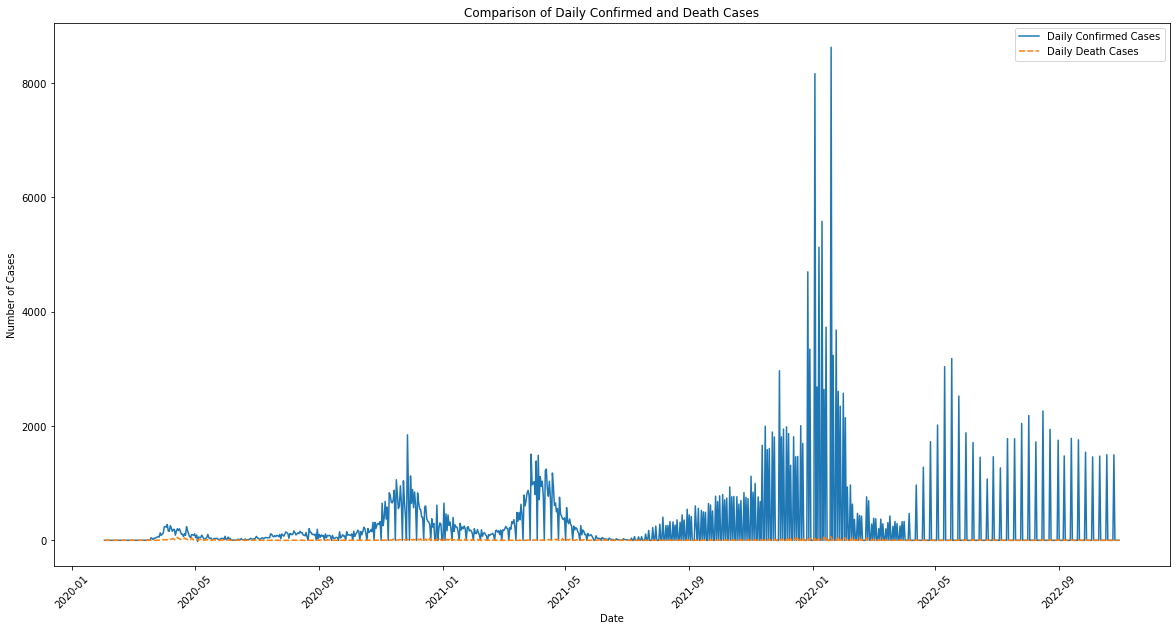

In [82]:

plt.rcParams["figure.figsize"] = (20,10)
sns.lineplot(data = combined[['Daily Confirmed Cases','Daily Death Cases']])
plt.title('Comparison of Daily Confirmed and Death Cases')
plt.xlabel('Date') 
plt.ylabel('Number of Cases') 
plt.xticks(rotation = 45);

We can see from the chart above that there are many days with 0 cases, likely due to data mishandling. This can be mitigated using rolling average. A 5 day rolling window has been chosen to smoothen the curve. Then we will study the percentage change of the 5-day moving average.

In [83]:
# Calculate the moving average
combined['5-day Moving Average for Confirmed Cases'] = combined['Daily Confirmed Cases'].rolling(5).mean()

# Calculate the percent change in moving average.
combined['Percent Change for Moving Average'] = combined['5-day Moving Average for Confirmed Cases'].pct_change()

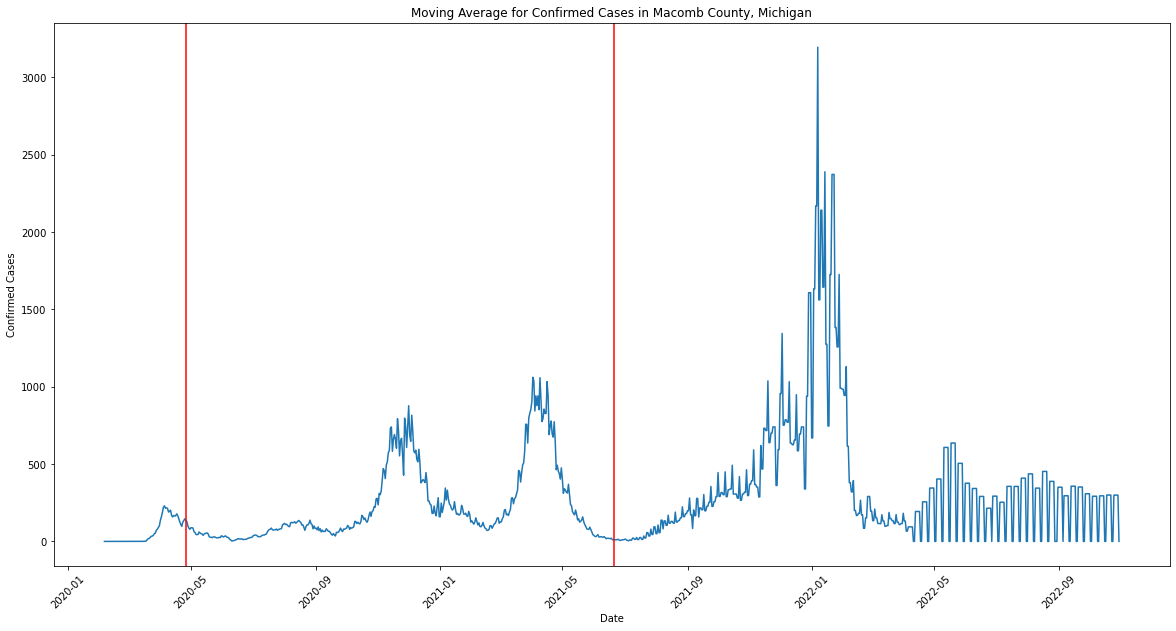

In [84]:
# Visualising the moving average
plt.rcParams["figure.figsize"] = (20,10)
sns.lineplot(data = combined['5-day Moving Average for Confirmed Cases'])
plt.axvline(x = pd.to_datetime('4/26/20'), color = 'r', label = 'Beginning of Mask Mandate')
plt.axvline(x = pd.to_datetime('6/21/21'), color = 'r', label = 'End of Mask Mandate')


plt.title('Moving Average for Confirmed Cases in Macomb County, Michigan')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.xticks(rotation = 45);

The period between the two red lines indicates the time where mask mandate is being enforced in Macomb county, Michigan. We can see that there are two peaks during that period. A quick search on the internet shows that during the first peak in November 2020 and December 2020, Macomb county went under a lock down, which could have flattened the curve. After mask mandate was lifted in June 2021, we can see a clear climb in cases starting in September 2021, which is the beginning of the Delta variant. 

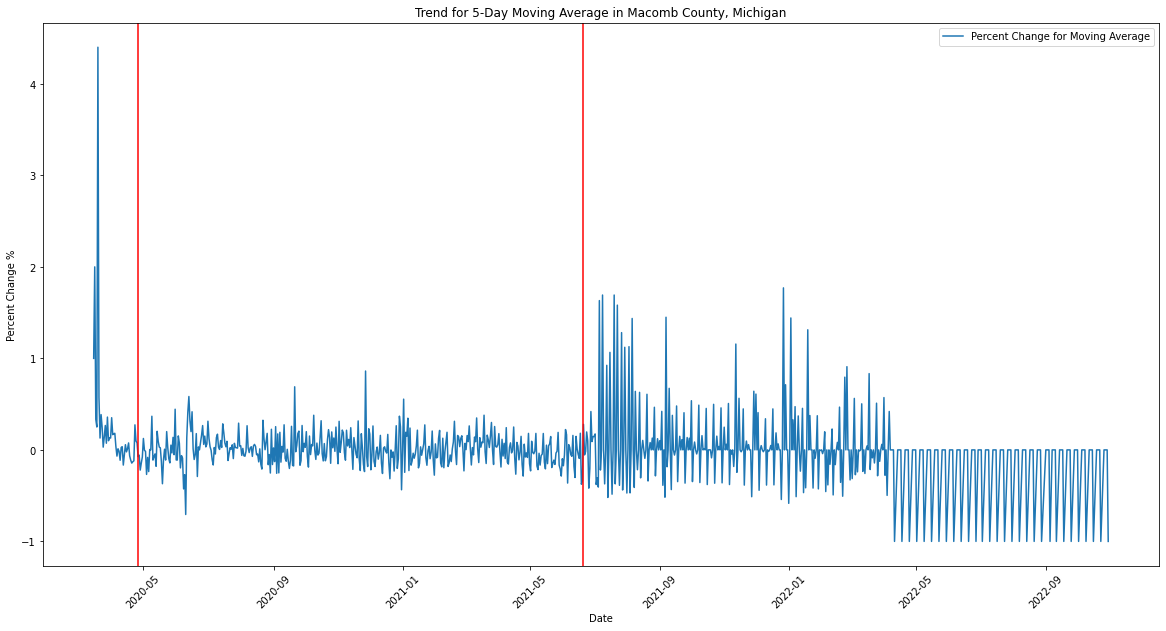

In [85]:
# Visualising the percent change
plt.title("Trend for 5-Day Moving Average in Macomb County, Michigan")
plt.rcParams["figure.figsize"] = (20,10)
sns.lineplot(data = combined[['Percent Change for Moving Average']])
plt.axvline(x = pd.to_datetime('4/26/20'), color = 'r', label = 'Beginning of Mask Mandate')
plt.axvline(x = pd.to_datetime('6/21/21'), color = 'r', label = 'Beginning of Mask Mandate')

plt.xlabel('Date')
plt.ylabel('Percent Change %')
plt.xticks(rotation = 45);

Here, we are taking a closer look at the impact of mask mandate by looking at the percentage change in confirmed cases. We can see during the period of mask mandate, the percentage change is constantly fluctuating around 0%. However, after the mask mandate has been lifted, the fluctuation increases by a big degree. The percentage change after April 2022 shows a very consistent trend and does not follow any patterns during the period before that. It is suspected that there are alot of data mishandling during this period.

## PART 2: Extension plan
#### The impact of vaccination rate, COVID-19 cases, deaths and unemployment rate in Macomb County, Michigan.
In the following part of the notebook, we will explore the impact of vaccination rate on the number of COVID-19 cases and deaths and the unemployment rate in Macomb County, Michigan. These three time series each has different time range and frequency, which will be standardized during the data cleaning procedure. The relationship between the three will be studied using Granger causality test and Pearson correlation test. 

### Reading in Data

Users should insert the data path that contains the excel file aggregated.xlsx under dir_path.

In [2]:
# Data path
dir_path = '<insert path here>'
data = 'aggregated.xlsx'
demographic_sheet = 'Demographics'         # file containing demographics of people receiving dosage.
dosage_sheet ='Dosage'                     # file containing number of people receiving dosage.
cases_sheet = 'Confirmed cases'            # file containing number of confirmed cases.
unemployment_sheet = 'Unemployment'        # file containing number of unemployment cases.

In [3]:
# Read in confirmed cases
cases = pd.read_excel(os.path.join(dir_path,data), sheet_name = cases_sheet )
cases.head()

,Date,Num_cases,Num_deaths
0,2020-01-23,0,0
1,2020-01-24,0,0
2,2020-01-25,0,0
3,2020-01-26,0,0
4,2020-01-27,0,0


In [4]:
# Read in demographic
demographic = pd.read_excel(os.path.join(dir_path,data), sheet_name = demographic_sheet )
demographic.head()

,Person's Residence in Preparedness Region,Person's Residence in Local Health Department Jurisdiction,Person's Residence in County,Sex,Age Group,Vaccine Type,Dose Number,Week Ending Date,Doses Administered
0,Region 2N,Macomb County Health Department,Macomb,F,16-19 years,Pfizer,First Dose,2020-12-26,8
1,Region 2N,Macomb County Health Department,Macomb,F,20-29 years,Moderna,First Dose,2020-12-26,11
2,Region 2N,Macomb County Health Department,Macomb,F,20-29 years,Pfizer,First Dose,2020-12-26,430
3,Region 2N,Macomb County Health Department,Macomb,F,20-29 years,Pfizer,Second Dose,2020-12-26,3
4,Region 2N,Macomb County Health Department,Macomb,F,30-39 years,Moderna,First Dose,2020-12-26,2


In [5]:
# Read in dosage
dosage = pd.read_excel(os.path.join(dir_path,data), sheet_name = dosage_sheet )
dosage.head()

,Person's Residence in Preparedness Region,Person's Residence in Local Health Department Jurisdiction,Person's Residence in County,Vaccine Type,Facility Type,Dose Number,Week Ending Date,Data as of,Number of Doses
0,Region 2N,Macomb County Health Department,Macomb,Pfizer,Hospital,First Dose,2020-12-26,2020-12-20,92
1,Region 2N,Macomb County Health Department,Macomb,Pfizer,Local Health Department,First Dose,2020-12-26,2020-12-20,9
2,Region 2N,Macomb County Health Department,Macomb,Pfizer,Pharmacy,First Dose,2020-12-26,2020-12-20,9
3,Region 2N,Macomb County Health Department,Macomb,Pfizer,Family Practice,First Dose,2020-12-26,2020-12-21,4
4,Region 2N,Macomb County Health Department,Macomb,Pfizer,Hospital,First Dose,2020-12-26,2020-12-21,888


In [6]:
# Read in unemployment
unemployment = pd.read_excel(os.path.join(dir_path,data), sheet_name = unemployment_sheet )
unemployment['Date'] = pd.to_datetime(unemployment['Date'].dt.strftime('%Y-%m'))
unemployment.dtypes

Date                 datetime64[ns]
Unemployment Rate           float64
dtype: object

### Data Cleaning and Manipulation

Considering that unemployment data is monthly frequency, we would need to aggregate cases, dosage and demographic into monthly frequency for better comparison.

In [7]:
# Aggregating cases, dosage and demographic
cases.dtypes
cases.index = pd.to_datetime(cases['Date'],format = 'YYYY-MM')
cases_gb = cases.groupby(pd.Grouper(freq = 'M'))['Num_cases','Num_deaths'].agg('sum')
cases_gb.head()

/var/folders/zd/c28nct6s5454q__hl8mn2xbc0000gn/T/ipykernel_64225/2110849900.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cases_gb = cases.groupby(pd.Grouper(freq = 'M'))['Num_cases','Num_deaths'].agg('sum')


,Num_cases,Num_deaths
Date,,
2020-01-31,0,0
2020-02-29,0,0
2020-03-31,855,40
2020-04-30,4701,582
2020-05-31,1286,224


In [8]:
dosage.dtypes
dosage.index = pd.to_datetime(dosage['Data as of'],format = 'YYYY-MM-DD')
dose_gb = dosage.groupby([pd.Grouper(freq = 'M'),'Dose Number'])['Number of Doses'].agg('sum')
dose_gb

Data as of  Dose Number
2020-12-31  First Dose       8919
            Second Dose        26
2021-01-31  First Dose      48074
            Second Dose     16525
2021-02-28  First Dose      57220
            Second Dose     50186
2021-03-31  First Dose     107777
            Second Dose     68753
2021-04-30  First Dose     129544
            Second Dose    104562
2021-05-31  First Dose      46902
            Second Dose     88315
2021-06-30  First Dose      17859
            Second Dose     36797
2021-07-31  First Dose      14552
            Second Dose     12794
2021-08-31  First Dose      19800
            Second Dose     15268
2021-09-30  First Dose      12503
            Second Dose     14903
2021-10-31  First Dose       9445
            Second Dose     10409
2021-11-30  First Dose      17535
            Second Dose      8699
2021-12-31  First Dose      16281
            Second Dose     14911
2022-01-31  First Dose      11057
            Second Dose     11246
2022-02-28  First Dose  

In [9]:
demographic.dtypes
demographic.index = pd.to_datetime(demographic['Week Ending Date'],format = 'YYYY-MM-DD')
demographic_gb = demographic.groupby([pd.Grouper(freq = 'M'),'Dose Number','Age Group'])['Doses Administered'].agg('sum')
demographic_gb

Week Ending Date  Dose Number  Age Group    
2020-12-31        First Dose   16-19 years        13
                               20-29 years       671
                               30-39 years       894
                               40-49 years       783
                               50-64 years      1122
                                                ... 
2022-11-30        Second Dose  30-39 years         4
                               40-49 years         4
                               5-11 years          6
                               under 5 years      11
                  Third Dose   under 5 years      10
Name: Doses Administered, Length: 432, dtype: int64

For this research, we will only be using vaccination dosage data. We can see that the aggregated results have multi layer index. We will then proceed to pivot the table to analyse the data better.  

In [10]:
# Pivot dose_gb
dose_df = pd.DataFrame(dose_gb).reset_index()
dose_df.rename(columns = {'Data as of':'Date'}, inplace = True)
dose_df = dose_df.pivot(index = 'Date', columns = 'Dose Number').reset_index()
dose_df['Date'] = pd.to_datetime(dose_df['Date'].dt.strftime('%Y-%m'))
dose_df

Date Number of Doses                       
Dose Number                 First Dose Second Dose Third Dose
0           2020-12-01          8919.0        26.0        NaN
1           2021-01-01         48074.0     16525.0        NaN
2           2021-02-01         57220.0     50186.0        NaN
3           2021-03-01        107777.0     68753.0        NaN
4           2021-04-01        129544.0    104562.0        NaN
5           2021-05-01         46902.0     88315.0        NaN
6           2021-06-01         17859.0     36797.0        NaN
7           2021-07-01         14552.0     12794.0        NaN
8           2021-08-01         19800.0     15268.0        NaN
9           2021-09-01         12503.0     14903.0        NaN
10          2021-10-01          9445.0     10409.0        NaN
11          2021-11-01         17535.0      8699.0        NaN
12          2021-12-01         16281.0     14911.0        NaN
13          2022-01-01         11057.0     11246.0        NaN
14          2022-02-01          3212.0      5787.0        NaN
15          2022-03-01          1916.0      2577.0        NaN
16          2022-04-01          1631.0      1951.0        NaN
17          2022-05-01          1603.0      1719.0        NaN
18          2022-06-01          1514.0      1339.0        NaN
19          2022-07-01          1923.0      1490.0        NaN
20          2022-08-01          1832.0      1665.0        NaN
21          2022-09-01           891.0      1039.0      240.0
22          2022-10-01           648.0       619.0      211.0
23          2022-11-01            19.0        12.0        7.0

In [11]:
cases_df = pd.DataFrame(cases_gb).reset_index()
cases_df['Date'] = pd.to_datetime(cases_df['Date'].dt.strftime('%Y-%m'))
cases_df

,Date,Num_cases,Num_deaths
0,2020-01-01,0,0
1,2020-02-01,0,0
2,2020-03-01,855,40
3,2020-04-01,4701,582
4,2020-05-01,1286,224
5,2020-06-01,517,70
6,2020-07-01,2089,20
7,2020-08-01,3332,32
8,2020-09-01,2039,56
9,2020-10-01,4911,74


We can see that the dataframe dosage has the fewest data points, hence we need to filter unemployment and cases dataframes by the date range of dosage which is [2020-12-01: 2022-11-01].

In [12]:
cases_df.dtypes

Date          datetime64[ns]
Num_cases              int64
Num_deaths             int64
dtype: object

In [13]:
# Filter month of unemployment and cases
cases_df = cases_df[cases_df['Date'] >= pd.to_datetime('2020-12-01', format = '%Y-%m-%d')]
print('Minimum timestamp datapoint for number of cases:', min(cases_df['Date']))
print('Maximum timestamp datapoint for number of cases:', max(cases_df['Date']))

unemployment = unemployment[unemployment['Date'] >= pd.to_datetime('2020-12-01')]
print('Minimum timestamp datapoint for unemployment data:', min(unemployment['Date']))
print('Maximum timestamp datapoint for unemployment data:', max(unemployment['Date']))

dose_df = dose_df[dose_df['Date'] <= pd.to_datetime('2022-10-01')]
print('Minimum timestamp datapoint for vaccination data:', min(dose_df['Date']))
print('Maximum timestamp datapoint for vaccination data:', max(dose_df['Date']))

Minimum timestamp datapoint: 2020-12-01 00:00:00
Maximum timestamp datapoint: 2022-10-01 00:00:00


In [15]:
print('Length of dosage: ',len(dose_df))
print('Length of cases: ',len(cases_df))
print('Length of unemployment: ',len(unemployment))

Length of dosage:  23
Length of cases:  23
Length of unemployment:  23


Now we can see that all three time series have equal length and time range. For the next step, we will set Date as the index in order for us to plot the line charts.

In [16]:
dose_df.set_index('Date',drop=True, inplace = True)
dose_df.columns = dose_df.columns.get_level_values(1)
dose_df

Dose Number,First Dose,Second Dose,Third Dose
Date,,,
2020-12-01,8919.0,26.0,NaN
2021-01-01,48074.0,16525.0,NaN
2021-02-01,57220.0,50186.0,NaN
2021-03-01,107777.0,68753.0,NaN
2021-04-01,129544.0,104562.0,NaN
2021-05-01,46902.0,88315.0,NaN
2021-06-01,17859.0,36797.0,NaN
2021-07-01,14552.0,12794.0,NaN
2021-08-01,19800.0,15268.0,NaN


In [17]:
#cases_df.set_index('Date',drop=True, inplace = True)
cases_df.columns = cases_df.columns.get_level_values(0)
cases_df

,Date,Num_cases,Num_deaths
11,2020-12-01,11767,323
12,2021-01-01,6379,259
13,2021-02-01,3083,107
14,2021-03-01,13643,58
15,2021-04-01,22003,203
16,2021-05-01,5017,194
17,2021-06-01,618,70
18,2021-07-01,1007,14
19,2021-08-01,4141,29
20,2021-09-01,6989,63


In [18]:
unemployment.set_index('Date',drop=True, inplace = True)
unemployment

,Unemployment Rate
Date,
2020-12-01,7.6
2021-01-01,7.0
2021-02-01,6.6
2021-03-01,6.6
2021-04-01,6.0
2021-05-01,6.3
2021-06-01,6.8
2021-07-01,7.3
2021-08-01,6.4


### Data Exploration and Visualisations

Each time series will be plotted as part of the visualisation procedure to observe any trends available. The blue vertical line on each chart represents the end of mask mandate in Macomb County on June 21, 2021. Macomb County has implemented mask mandate from April 26 2020 to June 21 2021. This fact is being retrieved from the first part of this analysis which reader can refer to [Part 1 of the research project](https://github.com/Kirsteenng/Human-Centered-Design/blob/main/data-512-homework_4/US%20COVID%20Analysis.ipynb).

Text(0, 0.5, 'Unemployment Rate(%)')

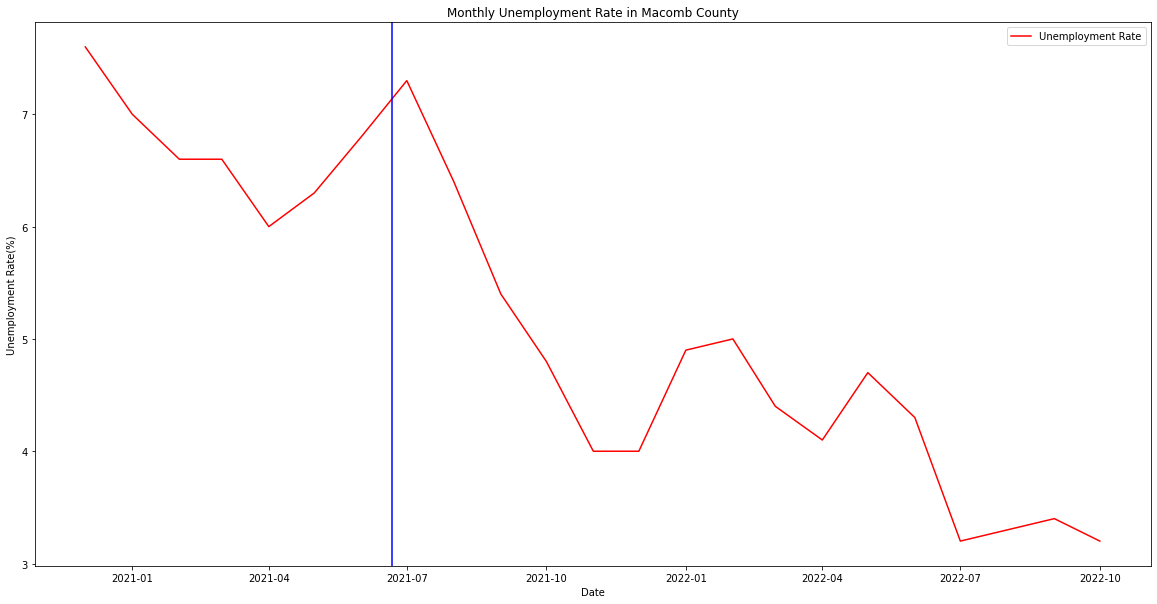

In [19]:
# Plotting monthly unemployment rate in Macomb County.
plt.rcParams["figure.figsize"] = (20,10)
sns.lineplot(data = unemployment, palette=['r'])

# This line represents the end of mask mandate.
plt.axvline(x = pd.to_datetime('6/21/21'), color = 'b', label = 'End of Mask Mandate')
plt.title('Monthly Unemployment Rate in Macomb County')
plt.xlabel('Date') 
plt.ylabel('Unemployment Rate(%)') 

The chart above shows that the highest monthly unemployment rate was in December 2020 at 7.6%. It has been dropping from December 2020 to April 2021 and bounced back to another peak on July 2021. Note that the mask mandate ended in June 2021, which is indicated by the blue line. Since the peak in July 2021, the unemployment rate has fallen to pre-COVID levels around 5%.

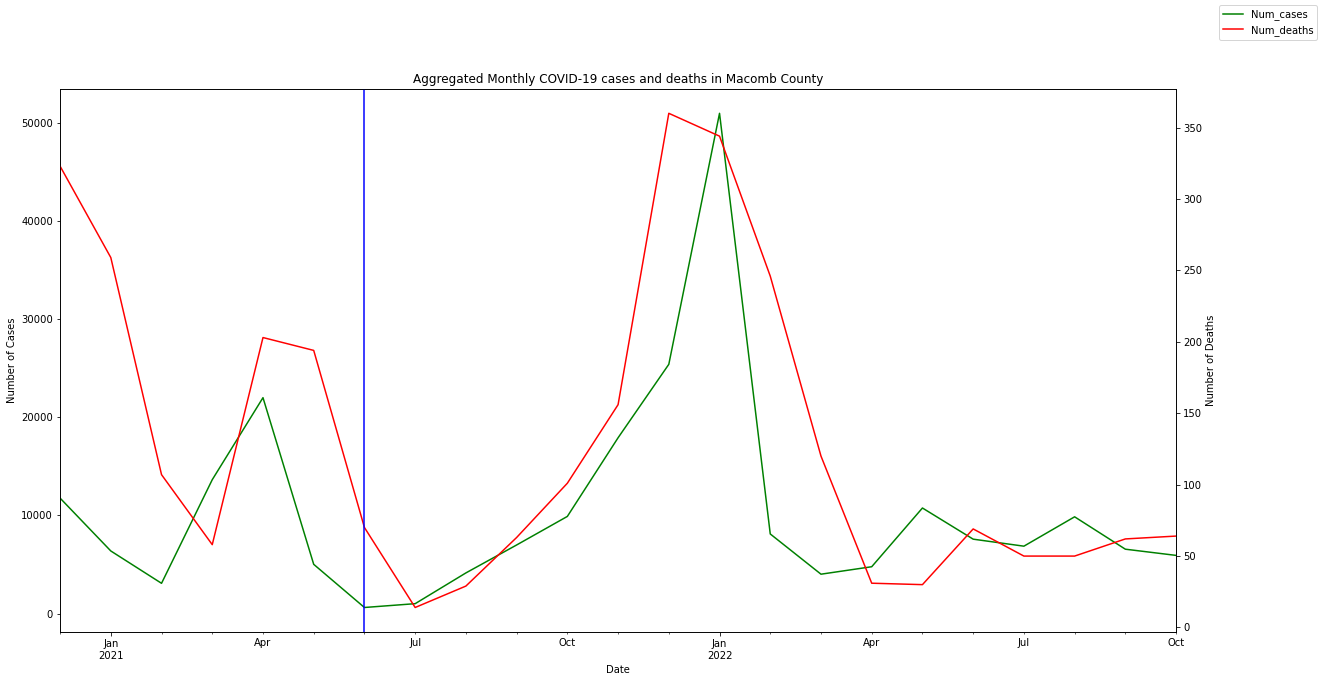

In [41]:

# Plotting aggregated monthly COVID-19 cases and deaths in Macomb County.
plt.rcParams["figure.figsize"] = (20,10)
ax = cases_df.plot(x="Date", y="Num_cases", legend=False,color="g")
ax2 = ax.twinx()
cases_df.plot(x="Date", y="Num_deaths", ax=ax2, legend=False, color="r")
ax.figure.legend()


# This line represents the end of mask mandate.
plt.axvline(x = pd.to_datetime('6/21/21'), color = 'b', label = 'End of Mask Mandate')
plt.title('Aggregated Monthly COVID-19 cases and deaths in Macomb County')
ax.set_ylabel('Number of Cases')
ax2.set_ylabel('Number of Deaths')
plt.show()

We can see from the chart above that the number of cases and the number of death display similar patterns. There are two peaks in this time range for both datasets; the number of case peaked around April 2021 and again in Janurary 2022. At the same time, the number of COVID-19 related deaths peaked in December 2020 and again in December 2021.

Text(0, 0.5, 'Amount of Vaccination')

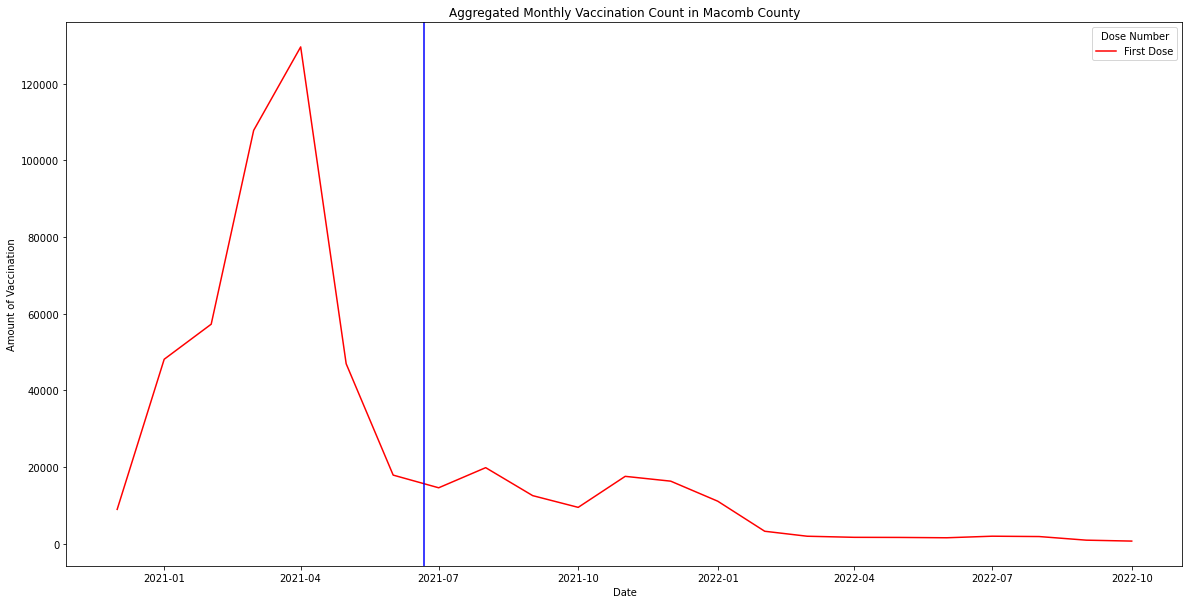

In [42]:
# Plotting aggregated monthly vaccination count in Macomb County.
plt.rcParams["figure.figsize"] = (20,10)
sns.lineplot(data = dose_df[['First Dose']], palette=['r'])

# This line represents the end of mask mandate.
plt.axvline(x = pd.to_datetime('6/21/21'), color = 'b', label = 'End of Mask Mandate')
plt.title('Aggregated Monthly Vaccination Count in Macomb County')
plt.xlabel('Date') 
plt.ylabel('Amount of Vaccination') 

### Data and Statistical Analysis

In [22]:

# Joining all four tables into one for easier analysis
joined_table = cases_df.join(unemployment, on ='Date').join(dose_df, on = 'Date')
joined_table.reset_index(inplace = True,drop = True)
joined_table


,Date,Num_cases,Num_deaths,Unemployment Rate,First Dose,Second Dose,Third Dose
0,2020-12-01,11767,323,7.6,8919.0,26.0,NaN
1,2021-01-01,6379,259,7.0,48074.0,16525.0,NaN
2,2021-02-01,3083,107,6.6,57220.0,50186.0,NaN
3,2021-03-01,13643,58,6.6,107777.0,68753.0,NaN
4,2021-04-01,22003,203,6.0,129544.0,104562.0,NaN
5,2021-05-01,5017,194,6.3,46902.0,88315.0,NaN
6,2021-06-01,618,70,6.8,17859.0,36797.0,NaN
7,2021-07-01,1007,14,7.3,14552.0,12794.0,NaN
8,2021-08-01,4141,29,6.4,19800.0,15268.0,NaN
9,2021-09-01,6989,63,5.4,12503.0,14903.0,NaN


#TODO: plot num_cases, num_death, unemployment
#TODO: plot num_cases, num_death, vaccination
#TODO: plot vaccination, unemployment


The first relationship that is being investigated in this research project is the number of cases and deaths. Because as shown by the chart above they demonstrate very similar patterns.

In [55]:
# Performing Granger-Causality test
grangercausalitytests(joined_table[['Num_deaths','Num_cases']], maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0856  , p=0.0361  , df_denom=19, df_num=1
ssr based chi2 test:   chi2=5.8886  , p=0.0152  , df=1
likelihood ratio test: chi2=5.2179  , p=0.0224  , df=1
parameter F test:         F=5.0856  , p=0.0361  , df_denom=19, df_num=1


{1: ({'ssr_ftest': (5.085631418669653, 0.0361142270700555, 19.0, 1),
   'ssr_chi2test': (5.888625853196441, 0.015238987118624245, 1),
   'lrtest': (5.217882490349751, 0.022355757121663117, 1),
   'params_ftest': (5.085631418669441, 0.03611422707005898, 19.0, 1.0)},
   array([[0., 1., 0.]])])}

A p-value of 0.0361 implies that the number of cases is a good predictor of number of deaths in Macomb County in this time range.

### Hypothesis 1: The number of cases and deaths are positively correlated to unemployment rate.
We then proceed to perform Granger causality test between unemployment rate and the number of COVID-19 cases and COVID-19 deaths. The number of lag chosen is 4 because it is assumed that the effect of COVID-19 cases on damaging the economy is not immediate.

In [45]:
# Performing Granger-Causality test
grangercausalitytests(joined_table[['Unemployment Rate', 'Num_cases']], maxlag=[4])


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5996  , p=0.6715  , df_denom=10, df_num=4
ssr based chi2 test:   chi2=4.5570  , p=0.3358  , df=4
likelihood ratio test: chi2=4.0847  , p=0.3947  , df=4
parameter F test:         F=0.5996  , p=0.6715  , df_denom=10, df_num=4


{4: ({'ssr_ftest': (0.5995998875894308, 0.6714676714555612, 10.0, 4),
   'ssr_chi2test': (4.5569591456796745, 0.3358469251358548, 4),
   'lrtest': (4.08466375257963, 0.39466909855488996, 4),
   'params_ftest': (0.5995998875950035, 0.6714676714519999, 10.0, 4.0)},
   array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

In [49]:
# Performing Granger-Causality test
grangercausalitytests(joined_table[['Unemployment Rate', 'Num_deaths']], maxlag=[4])


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6731  , p=0.6256  , df_denom=10, df_num=4
ssr based chi2 test:   chi2=5.1157  , p=0.2756  , df=4
likelihood ratio test: chi2=4.5301  , p=0.3390  , df=4
parameter F test:         F=0.6731  , p=0.6256  , df_denom=10, df_num=4


{4: ({'ssr_ftest': (0.6731185094891394, 0.6255678709767161, 10.0, 4),
   'ssr_chi2test': (5.115700672117459, 0.2756305734741018, 4),
   'lrtest': (4.530058458218761, 0.3389981888751847, 4),
   'params_ftest': (0.67311850948915, 0.6255678709767095, 10.0, 4.0)},
   array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

Both p-values above show that number of cases and death cannot be used to predict unemployment rate in Macomb County during this period because they are larger than 0.05. We then continue to study their correlation using two-tailed Pearson correlation test.

In [62]:
res0 = stats.pearsonr(joined_table['Num_deaths'],joined_table['Unemployment Rate'])
print('Correlation coefficient between number of deaths and unemployment: ', res0[0])
print('p-value between number of deaths and unemployment: ', res0[1])

Correlation coefficient between number of deaths and unemployment:  0.18376009129893292
p-value between number of deaths and unemployment:  0.4012907037991976


In [63]:
res1 = stats.pearsonr(joined_table['Num_cases'],joined_table['Unemployment Rate'])
print('Correlation coefficient between number of cases and unemployment: ', res1[0])
print('p-value between number of cases and unemployment: ', res1[1])

Correlation coefficient between number of cases and unemployment:  -0.15149289497691115
p-value between number of cases and unemployment:  0.49018342997731806


It turns out that p-values in both Pearson tests are above 0.05 and hence they are not statistically significant. 

### Hypothesis 2: The number of cases and deaths are negatively correlated to vaccination rate.
We then proceed to perform Granger causality test between vaccination rate and the number of COVID-19 cases and COVID-19 deaths. The number of lag chosen is 4 because it is assumed that it takes a while before the vaccination effect to take effect.

In [64]:
grangercausalitytests(joined_table[['Num_cases', 'First Dose']], maxlag=[4])


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2470  , p=0.9050  , df_denom=10, df_num=4
ssr based chi2 test:   chi2=1.8769  , p=0.7584  , df=4
likelihood ratio test: chi2=1.7898  , p=0.7743  , df=4
parameter F test:         F=0.2470  , p=0.9050  , df_denom=10, df_num=4


{4: ({'ssr_ftest': (0.2469540214058466, 0.9050297776106758, 10.0, 4),
   'ssr_chi2test': (1.8768505626844343, 0.7583961924703471, 4),
   'lrtest': (1.7898368096644504, 0.774341238944526, 4),
   'params_ftest': (0.24695402140584582, 0.9050297776106764, 10.0, 4.0)},
   array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

In [66]:
grangercausalitytests(joined_table[['Num_deaths', 'First Dose']], maxlag=[4])


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3346  , p=0.3228  , df_denom=10, df_num=4
ssr based chi2 test:   chi2=10.1431 , p=0.0381  , df=4
likelihood ratio test: chi2=8.1278  , p=0.0870  , df=4
parameter F test:         F=1.3346  , p=0.3228  , df_denom=10, df_num=4


{4: ({'ssr_ftest': (1.3346124323299715, 0.32275858470325924, 10.0, 4),
   'ssr_chi2test': (10.143054485707784, 0.03808567452219725, 4),
   'lrtest': (8.127775106190853, 0.0870081859255975, 4),
   'params_ftest': (1.3346124323298345, 0.32275858470330315, 10.0, 4.0)},
   array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

In [68]:
res2 = stats.pearsonr(joined_table['Num_cases'],joined_table['First Dose'])
print('Correlation coefficient between number of cases and vaccination: ', res2[0])
print('p-value between number of cases and vaccination: ', res2[1])

Correlation coefficient between number of cases and vaccination:  0.14823331207645643
p-value between number of cases and vaccination:  0.4996746879097489


In [69]:
res3 = stats.pearsonr(joined_table['Num_deaths'],joined_table['First Dose'])
print('Correlation coefficient between number of deaths and vaccination: ', res3[0])
print('p-value between number of deaths and vaccination: ', res3[1])

Correlation coefficient between number of deaths and vaccination:  0.13717245400060152
p-value between number of deaths and vaccination:  0.5325414606179324


We can see that number of cases and deaths are positively correlated to the number of vaccination in Macomb County, which is against the hypothesis of this research. The p-values indicate that the relationships are not statistically significant enough.

### Hypothesis 3: Unemployment rate and vaccination rate are positively correlated.

In [65]:
grangercausalitytests(joined_table[['Unemployment Rate', 'First Dose']], maxlag=[4])


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.5486  , p=0.0474  , df_denom=10, df_num=4
ssr based chi2 test:   chi2=26.9697 , p=0.0000  , df=4
likelihood ratio test: chi2=16.7873 , p=0.0021  , df=4
parameter F test:         F=3.5486  , p=0.0474  , df_denom=10, df_num=4


{4: ({'ssr_ftest': (3.5486422650848666, 0.04744395914979304, 10.0, 4),
   'ssr_chi2test': (26.969681214644986, 2.0161454286340454e-05, 4),
   'lrtest': (16.787318823784297, 0.0021257630029001937, 4),
   'params_ftest': (3.548642265217871, 0.04744395914512489, 10.0, 4.0)},
   array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

In [70]:
res4 =stats.pearsonr(joined_table['Unemployment Rate'], joined_table['First Dose'])
print('Correlation coefficient between unemployment and vaccination: ', res4[0])
print('p-value between unemployment and vaccination: ', res4[1])

Correlation coefficient between unemployment and vaccination:  0.48936868081660223
p-value between unemployment and vaccination:  0.01778948796650519


The final relationship between unemployment rate and vaccination rate agree with the third hypothesis and is statistically significant.